In [1]:
# That's an impressive list of imports.
import numpy as np
from numpy                  import linalg
from numpy.linalg           import norm
from scipy.spatial.distance import squareform, pdist
import scipy.sparse as sp
from scipy.sparse           import csr_matrix
import os
import sys
from time                   import time
from pprint                 import pprint

# We import sklearn.
import sklearn
from sklearn.base          import BaseEstimator
from sklearn.utils         import check_array, check_random_state
from sklearn.manifold      import TSNE
from sklearn.datasets      import load_digits
from sklearn.preprocessing import scale
from sklearn.neighbors     import NearestNeighbors
from sklearn.manifold      import _utils
from sklearn.manifold      import _barnes_hut_tsne


from sklearn.metrics.pairwise import pairwise_distances
from sklearn.manifold.t_sne   import _joint_probabilities, _joint_probabilities_nn, _kl_divergence_bh
from sklearn.manifold.t_sne   import _kl_divergence

# Random state.
RS = 20150101

MACHINE_EPSILON = np.finfo(np.double).eps

# We'll use matplotlib for graphics.
import matplotlib.pyplot      as plt
import matplotlib.patheffects as PathEffects
import matplotlib

%matplotlib inline

# We import seaborn to make nice plots.
import seaborn                as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

# We'll generate an animation with matplotlib and moviepy.
from moviepy.video.io.bindings import mplfig_to_npimage
import moviepy.editor          as mpy

In [2]:
digits = load_digits()

mu, sigma = 0, 0.01
noise = np.random.normal(mu, sigma, digits.data.shape)

noisy_digits = digits.data + noise

X       = np.vstack([digits.data[digits.target==i]   for i in range(10)])
noisy_X = np.vstack([noisy_digits[digits.target==i]  for i in range(10)])
y       = np.hstack([digits.target[digits.target==i] for i in range(10)])

In [3]:
def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

In [4]:
def make_frame_mpl(t):
    i = int(t*40)
    x = X_iter[..., i]
    sc.set_offsets(x)
    for j, txt in zip(range(10), txts):
        xtext, ytext = np.median(x[y == j, :], axis=0)
        txt.set_x(xtext)
        txt.set_y(ytext)
    return mplfig_to_npimage(f)

In [24]:
def _kl_divergence_prior(params, P, degrees_of_freedom, n_samples, n_components,
                         angle=0.5, skip_num_points=0, verbose=False,
                         compute_error=True, alpha=0, Q_zero=None):
    
    params = params.astype(np.float32, copy=False)
    
    X_embedded = params.reshape(n_samples, n_components)
    
    val_P = P.data.astype(np.float32, copy=False)
    
    neighbors = P.indices.astype(np.int64, copy=False)
    
    indptr = P.indptr.astype(np.int64, copy=False)

    grad = np.zeros(X_embedded.shape, dtype=np.float32)
    
#     print('P');print(type(P))
#     print(P.shape)
#     print('valP');print(type(val_P))
#     print(val_P.shape)
#     print('Q_zero');print(type(Q_zero))
#     print(Q_zero.shape)
#     print('P:');print(P.shape)
#     print('Q_zero:');print(Q_zero.shape)
    T = (1-alpha)*P + (alpha)*Q_zero
    
#     print('T');print(type(T))
#     print(T.shape)
    
    val_Q_zero        = Q_zero.data.astype(np.float32, copy=False)
    neighbors_Q_zero  = Q_zero.indices.astype(np.int64, copy=False)
    indptr_Q_zero     = Q_zero.indptr.astype(np.int64, copy=False)
    
#     print('valQ_zero');print(type(val_Q_zero))
#     print(val_Q_zero.shape)
    
    val_T        = T.data.astype(np.float32, copy=False)
    neighbors_T  = T.indices.astype(np.int64, copy=False)
    indptr_T     = T.indptr.astype(np.int64, copy=False)
    
#     print('val_T');print(type(val_T))
#     print(val_T.shape)
#     print('T:')
#     print(T)
#     print(val_T)
#     print('P:')
#     print(P)
#     print(val_P)
#     print('Q_zero:')
#     print(Q_zero)
#     print(val_Q_zero)
#     print('T-Q_zero:')
#     print(T-Q_zero)
#     print((T-Q_zero).data.astype(np.float32, copy=False))
#     print('T-P:')
#     print(T-P)
#     print((T-P).data.astype(np.float32, copy=False))
#     sys.exit()
    
    error = _barnes_hut_tsne.gradient(val_T, X_embedded, neighbors_T, indptr_T,
                                      grad, angle, n_components, verbose,
                                      dof=degrees_of_freedom,
                                     compute_error=compute_error)
    
#     error = _barnes_hut_tsne.gradient(val_T, X_embedded, neighbors_T, indptr_T,
#                                       grad, angle, n_components, verbose,
#                                       dof=degrees_of_freedom,
#                                       compute_error=compute_error)


    c = 2.0 * (degrees_of_freedom + 1.0) / degrees_of_freedom
    grad = grad.ravel()
    grad *= c

    return error, grad

In [6]:
def _gradient_descent(objective, p0, it, n_iter,
                      n_iter_check=1, n_iter_without_progress=300,
                      momentum=0.8, learning_rate=200.0, min_gain=0.01,
                      min_grad_norm=1e-7, verbose=0, args=None, kwargs=None):
    if args is None:
        args = []
    if kwargs is None:
        kwargs = {}

    p = p0.copy().ravel()
    update = np.zeros_like(p)
    gains = np.ones_like(p)
    error = np.finfo(np.float).max
    best_error = np.finfo(np.float).max
    best_iter = i = it

    tic = time()
    for i in range(it, n_iter):
        check_convergence = (i + 1) % n_iter_check == 0
        # only compute the error when needed
        kwargs['compute_error'] = check_convergence or i == n_iter - 1
        
        positions.append(p.copy())
        error, grad = objective(p, *args, **kwargs)
        grad_norm = linalg.norm(grad)

        inc = update * grad < 0.0
        dec = np.invert(inc)
        gains[inc] += 0.2
        gains[dec] *= 0.8
        np.clip(gains, min_gain, np.inf, out=gains)
        grad *= gains
        update = momentum * update - learning_rate * grad
        p += update

        if check_convergence:
            toc = time()
            duration = toc - tic
            tic = toc

            if verbose >= 2:
                print("[t-SNE] Iteration %d: error = %.7f,"
                      " gradient norm = %.7f"
                      " (%s iterations in %0.3fs)"
                      % (i + 1, error, grad_norm, n_iter_check, duration))

            if error < best_error:
                best_error = error
                best_iter = i
            elif i - best_iter > n_iter_without_progress:
                if verbose >= 2:
                    print("[t-SNE] Iteration %d: did not make any progress "
                          "during the last %d episodes. Finished."
                          % (i + 1, n_iter_without_progress))
                break
            if grad_norm <= min_grad_norm:
                if verbose >= 2:
                    print("[t-SNE] Iteration %d: gradient norm %f. Finished."
                          % (i + 1, grad_norm))
                break

    return p, error, i
                      
sklearn.manifold.t_sne._gradient_descent = _gradient_descent

In [27]:
class TSNE(BaseEstimator):

    # Control the number of exploration iterations with early_exaggeration on
    _EXPLORATION_N_ITER = 250

    # Control the number of iterations between progress checks
    _N_ITER_CHECK = 50

    def __init__(self, n_components=2, perplexity=30.0,
                 early_exaggeration=12.0, learning_rate=200.0, n_iter=1000,
                 n_iter_without_progress=300, min_grad_norm=1e-7,
                 metric="euclidean", init="random", verbose=0,
                 random_state=None, method='barnes_hut', angle=0.5):
        
        self.n_components = n_components
        self.perplexity = perplexity
        self.early_exaggeration = early_exaggeration
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        self.n_iter_without_progress = n_iter_without_progress
        self.min_grad_norm = min_grad_norm
        self.metric = metric
        self.init = init
        self.verbose = verbose
        self.random_state = random_state
        self.method = method
        self.angle = angle

    def _fit(self, X, skip_num_points=0):
        """Fit the model using X as training data.
        Note that sparse arrays can only be handled by method='exact'.
        It is recommended that you convert your sparse array to dense
        (e.g. `X.toarray()`) if it fits in memory, or otherwise using a
        dimensionality reduction technique (e.g. TruncatedSVD).
        Parameters
        ----------
        X : array, shape (n_samples, n_features) or (n_samples, n_samples)
            If the metric is 'precomputed' X must be a square distance
            matrix. Otherwise it contains a sample per row. Note that this
            when method='barnes_hut', X cannot be a sparse array and if need be
            will be converted to a 32 bit float array. Method='exact' allows
            sparse arrays and 64bit floating point inputs.
        skip_num_points : int (optional, default:0)
            This does not compute the gradient for points with indices below
            `skip_num_points`. This is useful when computing transforms of new
            data where you'd like to keep the old data fixed.
        """
        if self.method not in ['barnes_hut', 'exact', 'prior_t_sne']:
            raise ValueError("'method' must be 'barnes_hut' or 'exact'")
        if self.angle < 0.0 or self.angle > 1.0:
            raise ValueError("'angle' must be between 0.0 - 1.0")
        if self.metric == "precomputed":
            if isinstance(self.init, string_types) and self.init == 'pca':
                raise ValueError("The parameter init=\"pca\" cannot be "
                                 "used with metric=\"precomputed\".")
            if X.shape[0] != X.shape[1]:
                raise ValueError("X should be a square distance matrix")
            if np.any(X < 0):
                raise ValueError("All distances should be positive, the "
                                 "precomputed distances given as X is not "
                                 "correct")
        if self.method == 'barnes_hut' and sp.issparse(X):
            raise TypeError('A sparse matrix was passed, but dense '
                            'data is required for method="barnes_hut". Use '
                            'X.toarray() to convert to a dense numpy array if '
                            'the array is small enough for it to fit in '
                            'memory. Otherwise consider dimensionality '
                            'reduction techniques (e.g. TruncatedSVD)')
        if self.method == 'barnes_hut':
            X = check_array(X, ensure_min_samples=2,
                            dtype=[np.float32, np.float64])
        else:
            X = check_array(X, accept_sparse=['csr', 'csc', 'coo'],
                            dtype=[np.float32, np.float64])
        
        if self.method == 'barnes_hut' and self.n_components > 3:
            raise ValueError("'n_components' should be inferior to 4 for the "
                             "barnes_hut algorithm as it relies on "
                             "quad-tree or oct-tree.")
        random_state = check_random_state(self.random_state)

        if self.early_exaggeration < 1.0:
            raise ValueError("early_exaggeration must be at least 1, but is {}"
                             .format(self.early_exaggeration))

        if self.n_iter < 250:
            raise ValueError("n_iter should be at least 250")

        n_samples = X.shape[0]

        neighbors_nn = None
        if self.method == "exact":
            # Retrieve the distance matrix, either using the precomputed one or
            # computing it.
            if self.metric == "precomputed":
                distances = X
            else:
                if self.verbose:
                    print("[t-SNE] Computing pairwise distances...")

                if self.metric == "euclidean":
                    distances = pairwise_distances(X, metric=self.metric,
                                                   squared=True)
                else:
                    distances = pairwise_distances(X, metric=self.metric)

                if np.any(distances < 0):
                    raise ValueError("All distances should be positive, the "
                                     "metric given is not correct")

            # compute the joint probability distribution for the input space
            P = _joint_probabilities(distances, self.perplexity, self.verbose)
#             print(type(P))
#             print(P.shape)
#             sys.exit()
            
            assert np.all(np.isfinite(P)), "All probabilities should be finite"
            assert np.all(P >= 0), "All probabilities should be non-negative"
            assert np.all(P <= 1), ("All probabilities should be less "
                                    "or then equal to one")

        else:
            # Cpmpute the number of nearest neighbors to find.
            # LvdM uses 3 * perplexity as the number of neighbors.
            # In the event that we have very small # of points
            # set the neighbors to n - 1.
            k = min(n_samples - 1, int(3. * self.perplexity + 1))

            if self.verbose:
                print("[t-SNE] Computing {} nearest neighbors...".format(k))

            # Find the nearest neighbors for every point
            knn = NearestNeighbors(algorithm='auto', n_neighbors=k,
                                   metric=self.metric)
            t0 = time()
            knn.fit(X)
            duration = time() - t0
            if self.verbose:
                print("[t-SNE] Indexed {} samples in {:.3f}s...".format(
                    n_samples, duration))

            t0 = time()
            distances_nn, neighbors_nn = knn.kneighbors(
                None, n_neighbors=k)
            duration = time() - t0
            if self.verbose:
                print("[t-SNE] Computed neighbors for {} samples in {:.3f}s..."
                      .format(n_samples, duration))

            # Free the memory used by the ball_tree
            del knn

            if self.metric == "euclidean":
                # knn return the euclidean distance but we need it squared
                # to be consistent with the 'exact' method. Note that the
                # the method was derived using the euclidean method as in the
                # input space. Not sure of the implication of using a different
                # metric.
                distances_nn **= 2

            # compute the joint probability distribution for the input space
            P = _joint_probabilities_nn(distances_nn, neighbors_nn,
                                        self.perplexity, self.verbose)
            

        if isinstance(self.init, np.ndarray):
            X_embedded = self.init
        elif self.init == 'pca':
            pca = PCA(n_components=self.n_components, svd_solver='randomized',
                      random_state=random_state)
            X_embedded = pca.fit_transform(X).astype(np.float32, copy=False)
        elif self.init == 'random':
            # The embedding is initialized with iid samples from Gaussians with
            # standard deviation 1e-4.
            X_embedded = 1e-4 * random_state.randn(
                n_samples, self.n_components).astype(np.float32)
        else:
            raise ValueError("'init' must be 'pca', 'random', or "
                             "a numpy array")

        # Degrees of freedom of the Student's t-distribution. The suggestion
        # degrees_of_freedom = n_components - 1 comes from
        # "Learning a Parametric Embedding by Preserving Local Structure"
        # Laurens van der Maaten, 2009.
        degrees_of_freedom = max(self.n_components - 1, 1)

        return self._tsne(P, degrees_of_freedom, n_samples,
                          X_embedded=X_embedded,
                          neighbors=neighbors_nn,
                          skip_num_points=skip_num_points)

    def n_iter_final(self):
        return self.n_iter_

    def _tsne(self, P, degrees_of_freedom, n_samples, X_embedded,
              neighbors=None, skip_num_points=0):
        """Runs t-SNE."""
        # t-SNE minimizes the Kullback-Leiber divergence of the Gaussians P
        # and the Student's t-distributions Q. The optimization algorithm that
        # we use is batch gradient descent with two stages:
        # * initial optimization with early exaggeration and momentum at 0.5
        # * final optimization with momentum at 0.8
        params = X_embedded.ravel()

        opt_args = {
            "it": 0,
            "n_iter_check": self._N_ITER_CHECK,
            "min_grad_norm": self.min_grad_norm,
            "learning_rate": self.learning_rate,
            "verbose": self.verbose,
            "kwargs": dict(skip_num_points=skip_num_points),
            "args": [P, degrees_of_freedom, n_samples, self.n_components],
            "n_iter_without_progress": self._EXPLORATION_N_ITER,
            "n_iter": self._EXPLORATION_N_ITER,
            "momentum": 0.5,
        }
        if self.method == 'barnes_hut':
            obj_func = _kl_divergence_bh
            if self.verbose: print('[t-SNE] objective function chosen: Barnes Hut KL Divergence')
            opt_args['kwargs']['angle'] = self.angle
            # Repeat verbose argument for _kl_divergence_bh
            opt_args['kwargs']['verbose'] = self.verbose
            
        elif self.method == 'prior_t_sne' and not hasattr(self,'Q_zero'):
            obj_func = _kl_divergence_bh
            if self.verbose: print('[t-SNE] objective function chosen (First time only): Barnes Hut KL Divergence')
            opt_args['kwargs']['angle'] = self.angle
            opt_args['kwargs']['verbose'] = self.verbose
            self.Q_zero = None
            
        elif self.method == 'prior_t_sne':
            obj_func = _kl_divergence_prior
            if self.verbose: print('[t-SNE] objective function chosen: Prior KL Divergence')
            
            dist = pairwise_distances(self.embedding_, metric="sqeuclidean")
            dist /= degrees_of_freedom
            dist += 1.
            dist **= (degrees_of_freedom + 1.0) / -2.0
            Q_zero = np.maximum(dist / (2.0 * np.sum(dist)), MACHINE_EPSILON)
            
            self.Q_zero = csr_matrix(Q_zero)
            
#             if self.verbose: print("[t-SNE] Computing P pairwise distances...")

#             if self.metric == "euclidean": distancesP = pairwise_distances(X, metric=self.metric, squared=True)
            
#             else:                          distancesP = pairwise_distances(X, metric=self.metric)

#             if np.any(distances < 0):
#                 raise ValueError("All distances should be positive, the metric given is not correct")

#             # compute the joint probability distribution for the input space
#             P = _joint_probabilities(distancesP, self.perplexity, self.verbose)
            
#             opt_args["args"]['P'] = P
            
#             if self.verbose: print("[t-SNE] Computing Q_zero pairwise distances...")

#             if self.metric == "euclidean": distancesQ = pairwise_distances(self.embedding_, metric=self.metric, squared=True)
            
#             else:                          distancesQ = pairwise_distances(self.embedding_, metric=self.metric)

#             if np.any(distances < 0):
#                 raise ValueError("All distances should be positive, the metric given is not correct")
            
#             # compute the joint probability distribution for the output space (t-distributed)
#             # Currently same distribution as P!!!!!!
#             # need to edit _joint_probabilities to support t-distribution
#             self.Q_zero = _joint_probabilities(distancesQ, self.perplexity, self.verbose)
            
#             if self.verbose:
#                 print("[t-SNE] Q_zero Computed Successfully...")
                
            opt_args["kwargs"]['Q_zero'] = self.Q_zero
            opt_args["kwargs"]['alpha']  = 0
            
        else:
            obj_func = _kl_divergence
            if self.verbose: print('[t-SNE] objective function chosen: KL Divergence')

        # Learning schedule (part 1): do 250 iteration with lower momentum but
        # higher learning rate controlled via the early exageration parameter
        P *= self.early_exaggeration
        params, kl_divergence, it = _gradient_descent(obj_func, params,
                                                      **opt_args)
        if self.verbose:
            print("[t-SNE] KL divergence after %d iterations with early "
                  "exaggeration: %f" % (it + 1, kl_divergence))

        # Learning schedule (part 2): disable early exaggeration and finish
        # optimization with a higher momentum at 0.8
        P /= self.early_exaggeration
        remaining = self.n_iter - self._EXPLORATION_N_ITER
        if it < self._EXPLORATION_N_ITER or remaining > 0:
            opt_args['n_iter'] = self.n_iter
            opt_args['it'] = it + 1
            opt_args['momentum'] = 0.8
            opt_args['n_iter_without_progress'] = self.n_iter_without_progress
            params, kl_divergence, it = _gradient_descent(obj_func, params,
                                                          **opt_args)

        # Save the final number of iterations
        self.n_iter_ = it

        if self.verbose:
            print("[t-SNE] KL divergence after %d iterations: %f"
                  % (it + 1, kl_divergence))

        X_embedded = params.reshape(n_samples, self.n_components)
        self.kl_divergence_ = kl_divergence

        return X_embedded

    def fit_transform(self, X, y=None):
        """Fit X into an embedded space and return that transformed
        output.
        Parameters
        ----------
        X : array, shape (n_samples, n_features) or (n_samples, n_samples)
            If the metric is 'precomputed' X must be a square distance
            matrix. Otherwise it contains a sample per row.
        y : Ignored
        Returns
        -------
        X_new : array, shape (n_samples, n_components)
            Embedding of the training data in low-dimensional space.
        """
        embedding = self._fit(X)
        self.embedding_ = embedding
        return self.embedding_

    def fit(self, X, y=None):
        """Fit X into an embedded space.
        Parameters
        ----------
        X : array, shape (n_samples, n_features) or (n_samples, n_samples)
            If the metric is 'precomputed' X must be a square distance
            matrix. Otherwise it contains a sample per row. If the method
            is 'exact', X may be a sparse matrix of type 'csr', 'csc'
            or 'coo'.
        y : Ignored
        """
        self.fit_transform(X)
        return self

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1797 samples in 0.005s...
[t-SNE] Computed neighbors for 1797 samples in 0.289s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1797
[t-SNE] Computed conditional probabilities for sample 1797 / 1797
[t-SNE] Mean sigma: 8.121142
[t-SNE] objective function chosen: Barnes Hut KL Divergence
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.898624
[t-SNE] KL divergence after 1000 iterations: 0.748135
*******************************************************************************************************************************
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1797 samples in 0.004s...
[t-SNE] Computed neighbors for 1797 samples in 0.295s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1797
[t-SNE] Computed conditional probabilities for sample 1797 / 1797
[t-SNE] Mean sigma: 7.877879
[t-SNE] objective function chosen: Barnes Hut KL Divergence
[t-SNE] KL diver

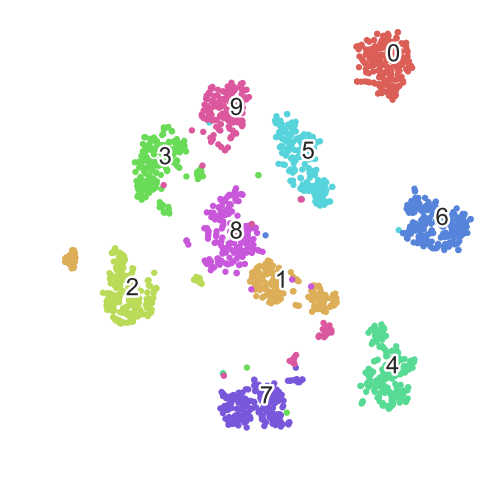

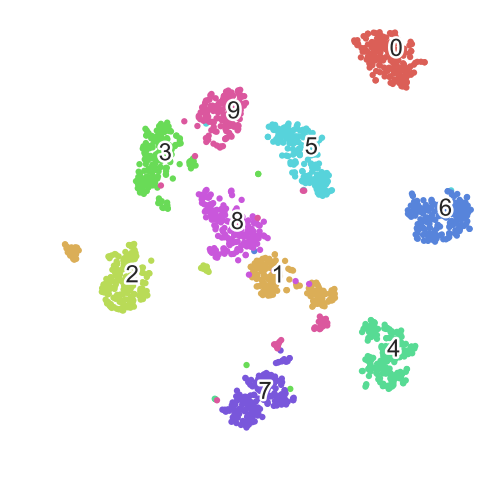

In [15]:
positions = []

tsne    = TSNE(random_state=RS, verbose=True)
X_proj  = tsne.fit_transform(X)
X_iter  = np.dstack(position.reshape(-1, 2) for position in positions)

f, ax, sc, txts = scatter(X_iter[..., -1], y)
f.savefig('init_raw_mnist_tsne')
# animation = mpy.VideoClip(make_frame_mpl, duration=X_iter.shape[2]/40.)
# animation.write_gif(os.path.join(os.getcwd(),'init_raw_mnist_tsne.gif'), fps=20)

print('*******************************************************************************************************************************')

positions = []

tsne    = TSNE(random_state=RS, verbose=True, init=X_proj)
X_proj  = tsne.fit_transform(noisy_X)
X_iter  = np.dstack(position.reshape(-1, 2) for position in positions)

f, ax, sc, txts = scatter(X_iter[..., -1], y)
f.savefig('init_noisy_raw_mnist_tsne')
# animation = mpy.VideoClip(make_frame_mpl, duration=X_iter.shape[2]/40.)
# animation.write_gif(os.path.join(os.getcwd(),'init_noisy_raw_mnist_tsne.gif'), fps=20)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1797 samples in 0.005s...
[t-SNE] Computed neighbors for 1797 samples in 0.286s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1797
[t-SNE] Computed conditional probabilities for sample 1797 / 1797
[t-SNE] Mean sigma: 8.121142
[t-SNE] objective function chosen: Barnes Hut KL Divergence
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.898624
[t-SNE] KL divergence after 1000 iterations: 0.748135
*******************************************************************************************************************************
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1797 samples in 0.004s...
[t-SNE] Computed neighbors for 1797 samples in 0.277s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1797
[t-SNE] Computed conditional probabilities for sample 1797 / 1797
[t-SNE] Mean sigma: 7.877879
[t-SNE] objective function chosen: Barnes Hut KL Divergence
[t-SNE] KL diver

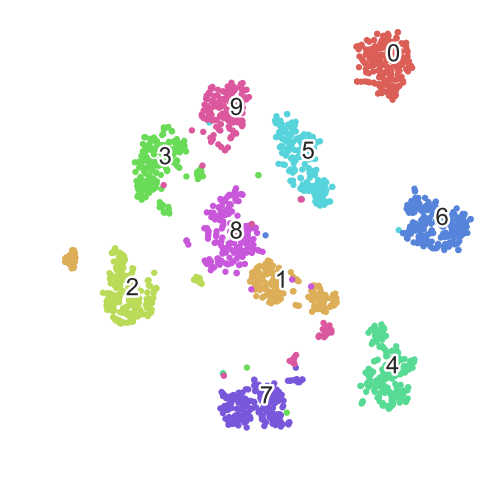

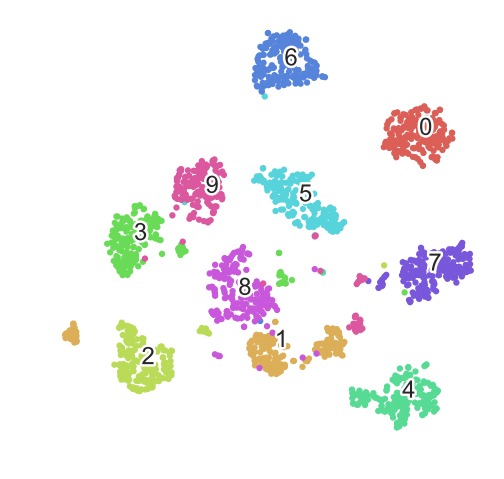

In [16]:
positions = []

tsne    = TSNE(random_state=RS, verbose=True)
X_proj  = tsne.fit_transform(X)
X_iter  = np.dstack(position.reshape(-1, 2) for position in positions)

f, ax, sc, txts = scatter(X_iter[..., -1], y)
f.savefig('regular_raw_mnist_tsne')
# animation = mpy.VideoClip(make_frame_mpl, duration=X_iter.shape[2]/40.)
# animation.write_gif(os.path.join(os.getcwd(),'regular_raw_mnist_tsne.gif'), fps=20)

print('*******************************************************************************************************************************')

positions = []

X_proj  = tsne.fit_transform(noisy_X)
X_iter  = np.dstack(position.reshape(-1, 2) for position in positions)

f, ax, sc, txts = scatter(X_iter[..., -1], y)
f.savefig('regular_noisy_raw_mnist_tsne')
# animation = mpy.VideoClip(make_frame_mpl, duration=X_iter.shape[2]/40.)
# animation.write_gif(os.path.join(os.getcwd(),'regular_noisy_raw_mnist_tsne.gif'), fps=20)


In [ ]:
positions = []

tsne_prior = TSNE(random_state=RS, method='prior_t_sne', verbose=True)
X_proj  = tsne_prior.fit_transform(X)
X_iter  = np.dstack(position.reshape(-1, 2) for position in positions)

f, ax, sc, txts = scatter(X_iter[..., -1], y)
f.savefig('prior_raw_mnist_tsne')
# animation = mpy.VideoClip(make_frame_mpl, duration=X_iter.shape[2]/40.)
# animation.write_gif(os.path.join(os.getcwd(),'prior_raw_mnist_tsne.gif'), fps=20)

print('*******************************************************************************************************************************')

positions = []

X_proj  = tsne_prior.fit_transform(noisy_X)
X_iter  = np.dstack(position.reshape(-1, 2) for position in positions)

f, ax, sc, txts = scatter(X_iter[..., -1], y)
f.savefig('prior_noisy_raw_mnist_tsne')
#animation = mpy.VideoClip(make_frame_mpl, duration=X_iter.shape[2]/40.)
#animation.write_gif(os.path.join(os.getcwd(),'prior_noisy_raw_mnist_tsne.gif'), fps=20)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1797 samples in 0.005s...
[t-SNE] Computed neighbors for 1797 samples in 0.287s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1797
[t-SNE] Computed conditional probabilities for sample 1797 / 1797
[t-SNE] Mean sigma: 8.121142
[t-SNE] objective function chosen (First time only): Barnes Hut KL Divergence
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.898624
[t-SNE] KL divergence after 1000 iterations: 0.748135
*******************************************************************************************************************************
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1797 samples in 0.004s...
[t-SNE] Computed neighbors for 1797 samples in 0.282s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1797
[t-SNE] Computed conditional probabilities for sample 1797 / 1797
[t-SNE] Mean sigma: 7.877879
[t-SNE] objective function chosen: Prior KL Divergence
[t-